<a href="https://colab.research.google.com/github/shreyash-alt/Emotion_Recognition_RAVDESS/blob/main/emotionravdess2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Getting the Dataset**

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyash24324021","key":"d7cee66ce8766696612dad63304c02bc"}'}

In [2]:
import os

os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-song-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 93% 400M/429M [00:00<00:00, 442MB/s]
100% 429M/429M [00:00<00:00, 500MB/s]
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-song-audio
License(s): CC-BY-NC-SA-4.0
 90% 409M/456M [00:00<00:00, 461MB/s]
100% 456M/456M [00:00<00:00, 491MB/s]


In [3]:
import zipfile
with zipfile.ZipFile("/content/ravdess-emotional-speech-audio.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/ravdess_speech")

with zipfile.ZipFile("/content/ravdess-emotional-song-audio.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/ravdess_song")

**Preprocessing**

In [4]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import seaborn as sns


In [5]:
def extract_emotion_features(filename, fixed_length=130):
    y, sr = librosa.load(filename, duration=4, offset=0)
    # MFCC + Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc = librosa.util.fix_length(mfcc, size=fixed_length, axis=1)

    delta = librosa.feature.delta(mfcc)
    delta = librosa.util.fix_length(delta, size=fixed_length, axis=1)

    delta2 = librosa.feature.delta(mfcc, order=2)
    delta2 = librosa.util.fix_length(delta2, size=fixed_length, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = librosa.util.fix_length(chroma, size=fixed_length, axis=1)

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = librosa.util.fix_length(contrast, size=fixed_length, axis=1)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = librosa.util.fix_length(zcr, size=fixed_length, axis=1)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth = librosa.util.fix_length(bandwidth, size=fixed_length, axis=1)

    # Pitch using librosa's piptrack
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_track = np.mean(pitches, axis=0)
    pitch_track = librosa.util.fix_length(pitch_track, size=fixed_length)
    pitch_feature = np.expand_dims(pitch_track, axis=0)


    # RMS energy
    rms = librosa.feature.rms(y=y)
    rms = librosa.util.fix_length(rms, size=fixed_length, axis=1)

    # Concatenate all features
    combined = np.concatenate((mfcc, delta,delta2, chroma, contrast, zcr, bandwidth, pitch_feature,rms), axis=0)

    return combined.T  # Shape: (time_steps, features)

In [6]:
def extract_label_from_filename(filename):
    modality=int(filename.split('-')[1])
    emotion_code = int(filename.split('-')[2])
    emotion_map = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }
    emotion=emotion_map.get(emotion_code)
    #return f"{modality}_{emotion}"
    return emotion

# Load file paths and labels
file_paths = []
labels = []

for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        if filename.endswith('.wav'):
            label = extract_label_from_filename(filename)
            if label:
                path = os.path.join(dirname, filename)
                file_paths.append(path)
                labels.append(label)

df = pd.DataFrame({'audio': file_paths, 'label': labels})
print(len(file_paths))

4904


In [7]:
X_features = [extract_emotion_features(f) for f in df['audio']]
X = np.array(X_features)
print(X.shape)

(4904, 130, 62)


/tmp/ipython-input-31-2598841033.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='bright')


<Axes: xlabel='label', ylabel='count'>

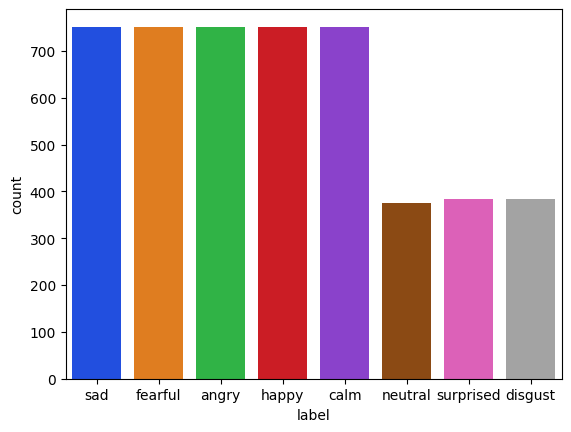

In [31]:
sns.countplot(x='label', data=df, palette='bright')

In [9]:


# Encoding labels to integers for class weighing
le = LabelEncoder()
y= le.fit_transform(df['label'])  # Integer labels for class_weight



# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)
# One-hot encoding for model training
y = to_categorical(y)
print(le.classes_)

{0: np.float64(0.8151595744680851), 1: np.float64(0.8151595744680851), 2: np.float64(1.5963541666666667), 3: np.float64(0.8151595744680851), 4: np.float64(0.8151595744680851), 5: np.float64(1.6303191489361701), 6: np.float64(0.8151595744680851), 7: np.float64(1.5963541666666667)}
['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
from sklearn.preprocessing import StandardScaler
import joblib

def normalize_train_val(X_train, X_val):
    # Flattening to 2D for scaler
    num_train, t, f = X_train.shape
    num_val = X_val.shape[0]

    X_train_flat = X_train.reshape(-1, f)
    X_val_flat = X_val.reshape(-1, f)

    # Fitting scaler only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_val_scaled = scaler.transform(X_val_flat)

    # Save the scaler for testscript and webapp
    joblib.dump(scaler, 'scaler.pkl')

    # Reshape back to original 3D shapes
    X_train_scaled = X_train_scaled.reshape(num_train, t, f)
    X_val_scaled = X_val_scaled.reshape(num_val, t, f)

    return X_train_scaled, X_val_scaled


In [12]:


X_train, X_val = normalize_train_val(X_train, X_val)
print(X_train.shape, X_val.shape)



(3923, 130, 62) (981, 130, 62)


**Model Training**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoints/epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_freq='epoch'
)
model = Sequential([


    Conv1D(64, 3, padding='same', activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=False)),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32,callbacks=[checkpoint_cb],class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.1822 - loss: 3.1997 - val_accuracy: 0.3109 - val_loss: 2.3367
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3121 - loss: 2.4690 - val_accuracy: 0.4363 - val_loss: 1.9820
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3878 - loss: 2.1762 - val_accuracy: 0.4822 - val_loss: 1.9085
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4596 - loss: 1.9324 - val_accuracy: 0.5739 - val_loss: 1.6412
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5477 - loss: 1.6990 - val_accuracy: 0.6453 - val_loss: 1.4528
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5992 - loss: 1.4936 - val_accuracy: 0.7543 - val_loss: 1.2054
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6687 - loss: 1.3507 - val_accuracy: 0.7482 - val_loss: 1.1808
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6963 - loss: 1.2748 -

**Evaluation**

In [15]:
#selecting max of average of train accuracy and validation accuracy to choose best model with less overfitting
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss=np.array(history.history['loss'])
val_loss=np.array(history.history['val_loss'])
avg_loss=(loss+val_loss)/2
avg_acc = (train_acc + val_acc) / 2
best_epoch = np.argmax(avg_acc) + 1  # +1 because epochs start from 1 in filenames

print(f"Best average (acc + val_acc)/2 at epoch {best_epoch},accuracy={train_acc[best_epoch-1]}, validation accuracy={val_acc[best_epoch-1]}, average value = {avg_acc[best_epoch-1]:.4f}")
history.model.load_weights(f"checkpoints/epoch_{best_epoch:02d}.weights.h5")
model.save("content/model.h5")



Best average (acc + val_acc)/2 at epoch 92,accuracy=0.9844506978988647, validation accuracy=0.9847095012664795, average value = 0.9846


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       150
        calm       1.00      0.99      0.99       151
     disgust       1.00      1.00      1.00        77
     fearful       0.99      0.99      0.99       150
       happy       0.99      0.95      0.97       150
     neutral       0.95      1.00      0.97        75
         sad       0.99      0.97      0.98       151
   surprised       0.94      1.00      0.97        77

    accuracy                           0.98       981
   macro avg       0.98      0.99      0.98       981
weighted avg       0.99      0.98      0.98       981



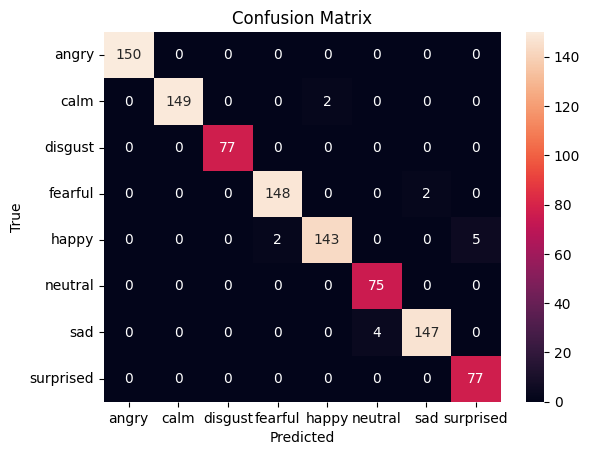

In [16]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
target_names = le.classes_


# Classification report
report =classification_report(y_true, y_pred_labels, target_names=target_names)
print(report)
with open("content/classification_report.txt", "w") as f:
    f.write(report)
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("content/confusion_matrix.png", dpi=300)
plt.show()

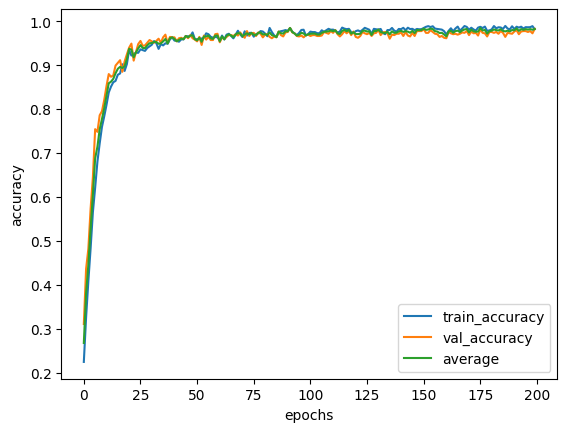

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='val_accuracy')
plt.plot(epochs,avg_acc,label='average')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

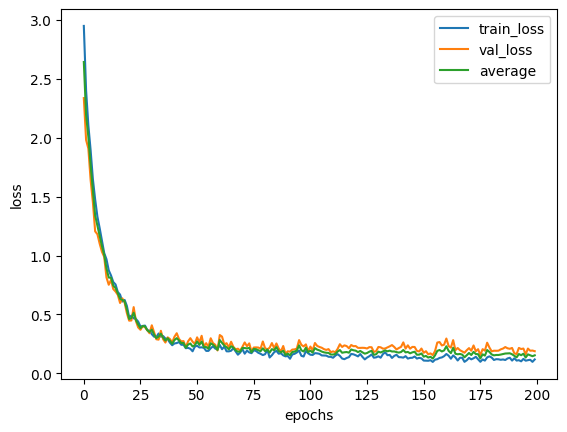

In [18]:
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.plot(epochs,avg_loss,label='average')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()